# Capital Cost of Compression

### Imports

In [62]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import MultipleLocator

import requests
from io import BytesIO

### Auxiliary Functions

In [63]:
def compression_power_stage(cp, m, r, t_in, M, eta_is, cr, z):
    """
    Compression Power Requirement (for each stage).
    """

    # Relationship between Specific Heat (Coefficient of Adiabatic Expansion, i.e., Cp/Cv)
    k = cp / z

    w_stage = (
        (1000 / (24 * 3600))
        * (m * z * r * t_in / (M * eta_is))
        * (k / (k - 1))
        * (cr ** (((k - 1) / k)) - 1)
    )

    return k, w_stage


def get_ylim(y_min, y_max):
    delta = 0.25 * (y_max - y_min)
    return (y_min - delta, y_max + delta)


def config_plot(ax, y_values, x_lim, title, leg_loc="upper right", x_multiplelocator=2):
    y_min, y_max = min(y_values), max(y_values)
    y_min_lim, y_max_lim = get_ylim(y_min, y_max)
    y_baseline = np.mean([y_min, y_min_lim])
    ax.set_ylim([y_min_lim, y_max_lim])

    ax.xaxis.set_major_locator(MultipleLocator(x_multiplelocator))
    ax.set_xlim(x_lim)

    # ax.grid(color="w", axis="y")
    ax.grid(axis="y", alpha=0.1)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.legend(loc=leg_loc, fontsize="small")
    ax.set_title(title)

### Data Reading

In [64]:
# URL = "https://raw.githubusercontent.com/thiagoneye/costcaster/main/data/Forecast%20(MtCO2e).xlsx"
# response = requests.get(URL)

# df = pd.read_excel(BytesIO(response.content), engine="openpyxl")

df = pd.read_excel("../data/Forecast (MtCO2e).xlsx")

df.drop(columns="Unnamed: 0", inplace=True)
df.set_index("Years", inplace=True)

display(df)

,A-1 - BAU,A-1 - DBM,A-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,S-1 - BAU,S-1 - DBM,S-1 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,1.341908,1.252185,1.320980,1.579306,1.519020,1.554676,13.513428,13.340975,13.302679,2.283988,2.074743,2.248368,23.632865,18.060261,23.264298,8.940516,9.801581,8.801084
2026,1.341908,1.242492,1.300379,1.579306,1.519730,1.530430,13.513428,13.317894,13.095216,2.283988,1.921093,2.213303,23.632865,17.756772,22.901478,8.940516,9.772826,8.663826
2027,1.341908,1.239475,1.280099,1.579306,1.519925,1.506562,13.513428,13.317618,12.890989,2.283988,1.776351,2.178785,23.632865,17.540634,22.544317,8.940516,9.788235,8.528709
2028,1.341908,1.238880,1.260135,1.579306,1.519972,1.483066,13.513428,13.319519,12.689947,2.283988,1.657053,2.144806,23.632865,17.448469,22.192726,8.940516,9.823698,8.395699
2029,1.341908,1.238803,1.240482,1.579306,1.519983,1.459937,13.513428,13.319376,12.492040,2.283988,1.569028,2.111357,23.632865,17.423024,21.846618,8.940516,9.856964,8.264763
2030,1.341908,1.238796,1.221136,1.579306,1.519985,1.437168,13.513428,13.318683,12.297220,2.283988,1.510201,2.078429,23.632865,17.418340,21.505907,8.940516,9.878516,8.135870


### Variables

In [65]:
p_initial = 0.1 # MPa Pressão Inicial Pi
p_final = 15  # MPa Pressão Final (Apagar) 
p_cutoff = 7.38  # MPa Pressão na Saída do Compressor (Renomear, agora é o final) Po
n_stage = 4 # Número de estágios
M = 44.01  # kg/kmol # Massa Molar do CO2
r = 8.314  # [kJ/kmol*K] R constante dos gases
t_in = 313.15  # K Temperatura de entrada
eta_is = 0.82 # Eficiência isentrópica no compressor
m = 25000 # Vazão mássica de CO2
rho = 630 # Densidade do CO2
np_ = 0.75 # Eficiência da bomba
dt = 356  # Temperature Variation During Compression

crf = 0.1275 # Capital Recovery Factor 
oem = 0.05 # Fator Operacional de Manutenção de OEM
p_e = 0.082 # Preço da Energia
cf = 0.8 # Fator de capacidade 

z1 = 0.995 # Razão de compressão para cada estágio de compressão
z2 = 0.986
z3 = 0.959
z4 = 0.875

list_of_companies = ["A-1", "C-1", "C-2", "P-1", "S-1", "S-2"]

COLORS = {
    "History": mcolors.CSS4_COLORS["darkslategray"],
    "Reference": mcolors.CSS4_COLORS["mediumturquoise"],
    "DBM": mcolors.CSS4_COLORS["goldenrod"],
    "GBM": mcolors.CSS4_COLORS["mediumseagreen"],
    "BAU": mcolors.CSS4_COLORS["indianred"],
}

### Analysis

In [66]:
cr = (p_cutoff / p_initial) ** (1 / n_stage)

cv = (13.946 + (5.981e-2 * dt) - (3.501e-5 * dt**2) + (7.469e-9 * dt**3)) / 44.01
cp = (22.26 + (5.981e-2 * dt) - (3.501e-5 * dt**2) + (7.469e-9 * dt**3)) / (44.01 * cv)

# Compression Power Requirement (for each stage)

k1, w_stage1 = compression_power_stage(cp, m, r, t_in, M, eta_is, cr, z=z1)
k2, w_stage2 = compression_power_stage(cp, m, r, t_in, M, eta_is, cr, z=z2)
k3, w_stage3 = compression_power_stage(cp, m, r, t_in, M, eta_is, cr, z=z3)
k4, w_stage4 = compression_power_stage(cp, m, r, t_in, M, eta_is, cr, z=z4)

# Convertion to tCO2e

df = df * 1e6

# Carbon Capture Percentage

df_ccp = df.copy()
df_ccp = df_ccp * 0.76
df_ccp = df_ccp.round(0).astype(int)

display(df_ccp)

,A-1 - BAU,A-1 - DBM,A-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,S-1 - BAU,S-1 - DBM,S-1 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,1019850,951660,1003945,1200273,1154455,1181554,10270205,10139141,10110036,1735831,1576805,1708759,17960978,13725798,17680866,6794792,7449201,6688824
2026,1019850,944294,988288,1200273,1154995,1163127,10270205,10121600,9952364,1735831,1460031,1682110,17960978,13495147,17405123,6794792,7427348,6584508
2027,1019850,942001,972875,1200273,1155143,1144987,10270205,10121390,9797152,1735831,1350027,1655877,17960978,13330882,17133681,6794792,7439059,6481819
2028,1019850,941549,957702,1200273,1155179,1127130,10270205,10122834,9644360,1735831,1259360,1630053,17960978,13260836,16866471,6794792,7466011,6380731
2029,1019850,941490,942767,1200273,1155187,1109552,10270205,10122726,9493950,1735831,1192461,1604631,17960978,13241498,16603429,6794792,7491293,6281220
2030,1019850,941485,928064,1200273,1155188,1092248,10270205,10122199,9345887,1735831,1147753,1579606,17960978,13237938,16344490,6794792,7507672,6183261


### Power Requirement

,A-1 - BAU,A-1 - DBM,A-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,S-1 - BAU,S-1 - DBM,S-1 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,10956,10223,10785,12894,12402,12693,110329,108921,108608,18647,16939,18356,192947,147451,189938,72994,80024,71855
2026,10956,10144,10617,12894,12408,12495,110329,108732,106914,18647,15685,18070,192947,144973,186976,72994,79789,70735
2027,10956,10120,10451,12894,12409,12300,110329,108730,105247,18647,14503,17788,192947,143208,184060,72994,79915,69631
2028,10956,10115,10288,12894,12410,12108,110329,108745,103605,18647,13529,17511,192947,142456,181189,72994,80204,68546
2029,10956,10114,10128,12894,12410,11919,110329,108744,101990,18647,12810,17238,192947,142248,178364,72994,80476,67477
2030,10956,10114,9970,12894,12410,11734,110329,108739,100399,18647,12330,16969,192947,142210,175582,72994,80652,66424


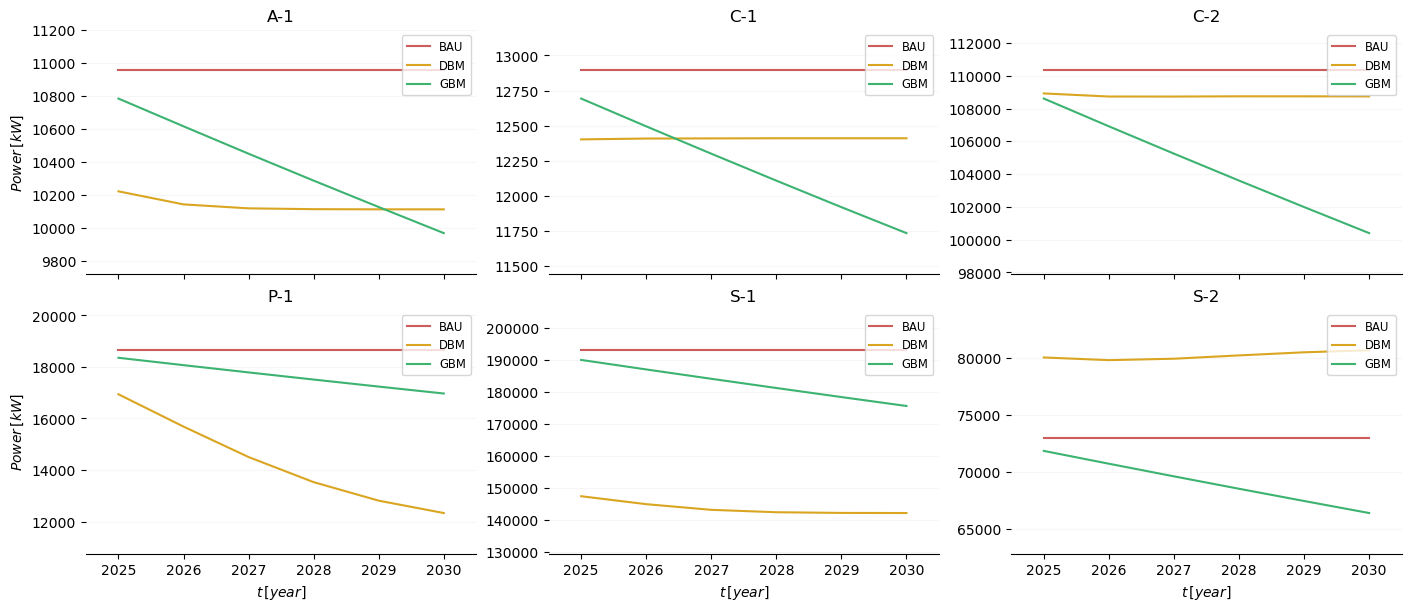

In [67]:
# Power Requirement [kW]

df_pr =((1000/(24*3600))*((df_ccp/365)*z1*r*t_in/(M*eta_is))*(k1/(k1-1))*(cr**(((k1-1)/k1))-1))+((1000/(24*3600))*((df_ccp/365)*z2*r*t_in/(M*eta_is))*(k2/(k2-1))*(cr**(((k2-1)/k2))-1))+((1000/(24*3600))*((df_ccp/365)*z3*r*t_in/(M*eta_is))*(k3/(k3-1))*(cr**(((k3-1)/k3))-1))+((1000/(24*3600))*((df_ccp/365)*z4*r*t_in/(M*eta_is))*(k4/(k4-1))*(cr**(((k4-1)/k4))-1))
df_pr = df_pr.round(0).astype(int)
display(df_pr)

# Plot

fig, axs = plt.subplots(2, 3, figsize=(14, 6), constrained_layout=True, sharex=True)
axs = axs.flatten()

for company_id, company_name in enumerate(list_of_companies):
    ax = axs[company_id]
    X = df_pr.index.values
    y_values = None

    # BAU
    column_name = f"{company_name} - BAU"
    data = df_pr.loc[:, column_name].values
    y_values = data
    ax.plot(X, data, color=COLORS["BAU"], label="BAU")

    # DBM
    column_name = f"{company_name} - DBM"
    data = df_pr.loc[:, column_name].values
    y_values = np.concatenate((y_values, data))
    ax.plot(X, data, color=COLORS["DBM"], label="DBM")

    # GBM
    column_name = f"{company_name} - GBM"
    data = df_pr.loc[:, column_name].values
    y_values = np.concatenate((y_values, data))
    ax.plot(X, data, color=COLORS["GBM"], label="GBM")

    config_plot(
        ax,
        y_values,
        x_lim=[2025 - 0.5, 2031 - 0.5],
        title=company_name,
        x_multiplelocator=1,
    )

    if company_id in [0, 3]:
        ax.set_ylabel("$Power \\, [kW]$")

    if company_id >= 3:
        ax.set_xlabel("$t \\, [year]$")

fig.savefig(f"../img/power_requirement.png", dpi=600, bbox_inches="tight")

### Capital Cost of Compression

,A-1 - BAU,A-1 - DBM,A-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,S-1 - BAU,S-1 - DBM,S-1 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,51717758,50311361,51394903,55185532,54336366,54841000,196991185,195985116,195760642,63924866,61523532,63525702,373459733,282197088,371126949,167082677,173320192,166039126
2026,51717758,50155857,51074064,55185532,54346491,54498623,196991185,195849877,194537786,63924866,59665873,63129044,373459733,280297050,368808753,167082677,173117337,165002093
2027,51717758,50107301,50755227,55185532,54349266,54158378,196991185,195848257,193322584,63924866,57832320,62734873,373459733,278931952,366505056,167082677,173226092,163971544
2028,51717758,50097721,50438374,55185532,54349941,53820261,196991185,195859395,192114975,63924866,56252331,62343163,373459733,278346772,364215752,167082677,173475991,162947433
2029,51717758,50096471,50123530,55185532,54350091,53484267,196991185,195858562,190914909,63924866,55042144,61953890,373459733,278184891,304442739,167082677,173709914,161929729
2030,51717758,50096365,49810634,55185532,54350109,53150371,196991185,195854497,189722356,63924866,54210467,61567058,373459733,278155074,302540927,167082677,173861208,160918388


,A-1 - BAU,A-1 - DBM,A-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,S-1 - BAU,S-1 - DBM,S-1 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,4720,4921,4765,4280,4381,4321,1785,1799,1802,3428,3632,3461,1936,1914,1954,2289,2166,2311
2026,4720,4944,4811,4280,4380,4362,1785,1801,1820,3428,3804,3494,1936,1933,1972,2289,2170,2333
2027,4720,4951,4856,4280,4380,4403,1785,1801,1837,3428,3988,3527,1936,1948,1991,2289,2168,2355
2028,4720,4953,4903,4280,4380,4445,1785,1801,1854,3428,4158,3560,1936,1954,2010,2289,2163,2377
2029,4720,4953,4949,4280,4380,4487,1785,1801,1872,3428,4297,3594,1936,1956,1707,2289,2159,2400
2030,4720,4953,4996,4280,4380,4530,1785,1801,1890,3428,4397,3628,1936,1956,1723,2289,2156,2423


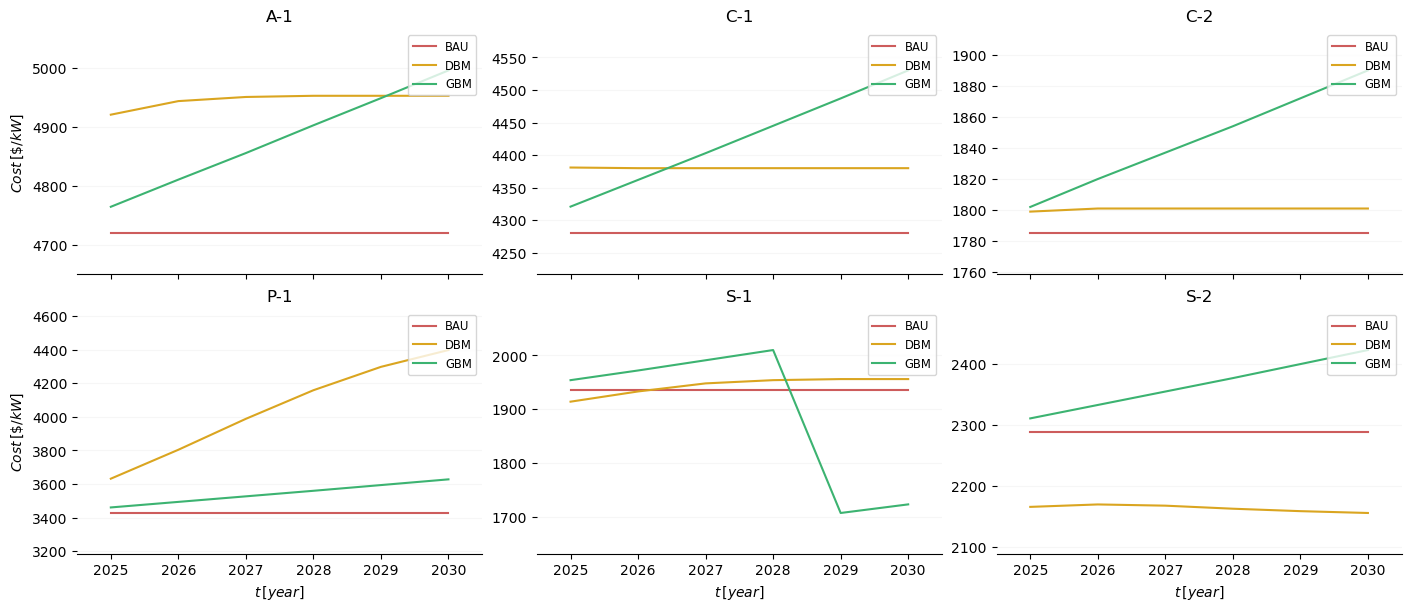

In [68]:
# Capital Cost of Compression ($)

repeated_term = (1000 * df_ccp / 365) / (24 * 3600 * np.ceil(df_pr / 60000))
df_ccc_m = (
    ((1000 * df_ccp / 365) / (24 * 3600))
    * (
        (0.13 * (10**6) / (repeated_term**0.71))
        + (1.4 * (10**6) * np.log(p_cutoff / p_initial) / (repeated_term**0.6))
    )
    * 2.107
)
df_ccc_m = df_ccc_m.round(0).astype(int)
display(df_ccc_m)

# Capital Cost of Compression ($/kW)

df_ccc = df_ccc_m/df_pr
df_ccc = df_ccc.round(0).astype(int)
display(df_ccc)

# Plot

fig, axs = plt.subplots(2, 3, figsize=(14, 6), constrained_layout=True, sharex=True)
axs = axs.flatten()

for company_id, company_name in enumerate(list_of_companies):
    ax = axs[company_id]
    X = df_ccc.index.values
    y_values = None

    # BAU
    column_name = f"{company_name} - BAU"
    data = df_ccc.loc[:, column_name].values
    y_values = data
    ax.plot(X, data, color=COLORS["BAU"], label="BAU")

    # DBM
    column_name = f"{company_name} - DBM"
    data = df_ccc.loc[:, column_name].values
    y_values = np.concatenate((y_values, data))
    ax.plot(X, data, color=COLORS["DBM"], label="DBM")

    # GBM
    column_name = f"{company_name} - GBM"
    data = df_ccc.loc[:, column_name].values
    y_values = np.concatenate((y_values, data))
    ax.plot(X, data, color=COLORS["GBM"], label="GBM")

    config_plot(
        ax,
        y_values,
        x_lim=[2025 - 0.5, 2031 - 0.5],
        title=company_name,
        x_multiplelocator=1,
    )

    if company_id in [0, 3]:
        ax.set_ylabel("$Cost \\, [\$/kW]$")

    if company_id >= 3:
        ax.set_xlabel("$t \\, [year]$")

fig.savefig(f"../img/capital_cost_of_compression.png", dpi=600, bbox_inches="tight")

### Annual Compression Capital Cost

,A-1 - BAU,A-1 - DBM,A-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,S-1 - BAU,S-1 - DBM,S-1 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,6594014,6414699,6552850,7036155,6927887,6992228,25116376,24988102,24959482,8150420,7844250,8099527,47616116,35980129,47318686,21303041,22098324,21169989
2026,6594014,6394872,6511943,7036155,6929178,6948574,25116376,24970859,24803568,8150420,7607399,8048953,47616116,35737874,47023116,21303041,22072460,21037767
2027,6594014,6388681,6471291,7036155,6929531,6905193,25116376,24970653,24648629,8150420,7373621,7998696,47616116,35563824,46729395,21303041,22086327,20906372
2028,6594014,6387459,6430893,7036155,6929617,6862083,25116376,24972073,24494659,8150420,7172172,7948753,47616116,35489213,46437508,21303041,22118189,20775798
2029,6594014,6387300,6390750,7036155,6929637,6819244,25116376,24971967,24341651,8150420,7017873,7899121,47616116,35468574,38816449,21303041,22148014,20646040
2030,6594014,6387287,6350856,7036155,6929639,6776672,25116376,24971448,24189600,8150420,6911835,7849800,47616116,35464772,38573968,21303041,22167304,20517094


,A-1 - BAU,A-1 - DBM,A-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,S-1 - BAU,S-1 - DBM,S-1 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,2585888,2515568,2569745,2759277,2716818,2742050,9849559,9799256,9788032,3196243,3076177,3176285,18672987,14109854,18556347,8354134,8666010,8301956
2026,2585888,2507793,2553703,2759277,2717325,2724931,9849559,9792494,9726889,3196243,2983294,3156452,18672987,14014852,18440438,8354134,8655867,8250105
2027,2585888,2505365,2537761,2759277,2717463,2707919,9849559,9792413,9666129,3196243,2891616,3136744,18672987,13946598,18325253,8354134,8661305,8198577
2028,2585888,2504886,2521919,2759277,2717497,2691013,9849559,9792970,9605749,3196243,2812617,3117158,18672987,13917339,18210788,8354134,8673800,8147372
2029,2585888,2504824,2506176,2759277,2717505,2674213,9849559,9792928,9545745,3196243,2752107,3097694,18672987,13909245,15222137,8354134,8685496,8096486
2030,2585888,2504818,2490532,2759277,2717505,2657519,9849559,9792725,9486118,3196243,2710523,3078353,18672987,13907754,15127046,8354134,8693060,8045919


,A-1 - BAU,A-1 - DBM,A-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,S-1 - BAU,S-1 - DBM,S-1 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,6295931,5874708,6197665,7409614,7126884,7294109,63401222,62592106,62412239,10715610,9734098,10548386,110878151,84733602,109149011,41946440,45986272,41291907
2026,6295931,5829310,6101123,7409614,7130332,7180327,63401222,62483496,61438772,10715610,9013479,10384034,110878151,83309604,107446880,41946440,45851228,40648292
2027,6295931,5815519,6005730,7409614,7130906,7068269,63401222,62482347,60480820,10715610,8334236,10221981,110878151,82295336,105771183,41946440,45923634,40013872
2028,6295931,5812645,5912061,7409614,7131481,6957935,63401222,62490967,59537235,10715610,7774521,10062801,110878151,81863195,104121346,41946440,46089710,39390370
2029,6295931,5812071,5820116,7409614,7131481,6849325,63401222,62490392,58609165,10715610,7361343,9905920,110878151,81743667,102497943,41946440,46246016,38776063
2030,6295931,5812071,5729320,7409614,7131481,6743014,63401222,62487519,57694888,10715610,7085508,9751338,110878151,81721830,100899250,41946440,46347156,38170950


,A-1 - BAU,A-1 - DBM,A-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,S-1 - BAU,S-1 - DBM,S-1 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,15475833,14804975,15320260,17205046,16771589,17028387,98367157,97379464,97159753,22062273,20654525,21824198,177167254,134823585,175024044,71603615,76750606,70763852
2026,15475833,14731975,15166769,17205046,16776835,16853832,98367157,97246849,95969229,22062273,19604172,21589439,177167254,133062330,172910434,71603615,76579555,69936164
2027,15475833,14709565,15014782,17205046,16777900,16681381,98367157,97245413,94795578,22062273,18599473,21357421,177167254,131805758,170825831,71603615,76671266,69118821
2028,15475833,14704990,14864873,17205046,16778595,16511031,98367157,97256010,93637643,22062273,17759310,21128712,177167254,131269747,168769642,71603615,76881699,68313540
2029,15475833,14704195,14717042,17205046,16778623,16342782,98367157,97255287,92496561,22062273,17131323,20902735,177167254,131121486,156536529,71603615,77079526,67518589
2030,15475833,14704176,14570708,17205046,16778625,16177205,98367157,97251692,91370606,22062273,16707866,20679491,177167254,131094356,154600264,71603615,77207520,66733963


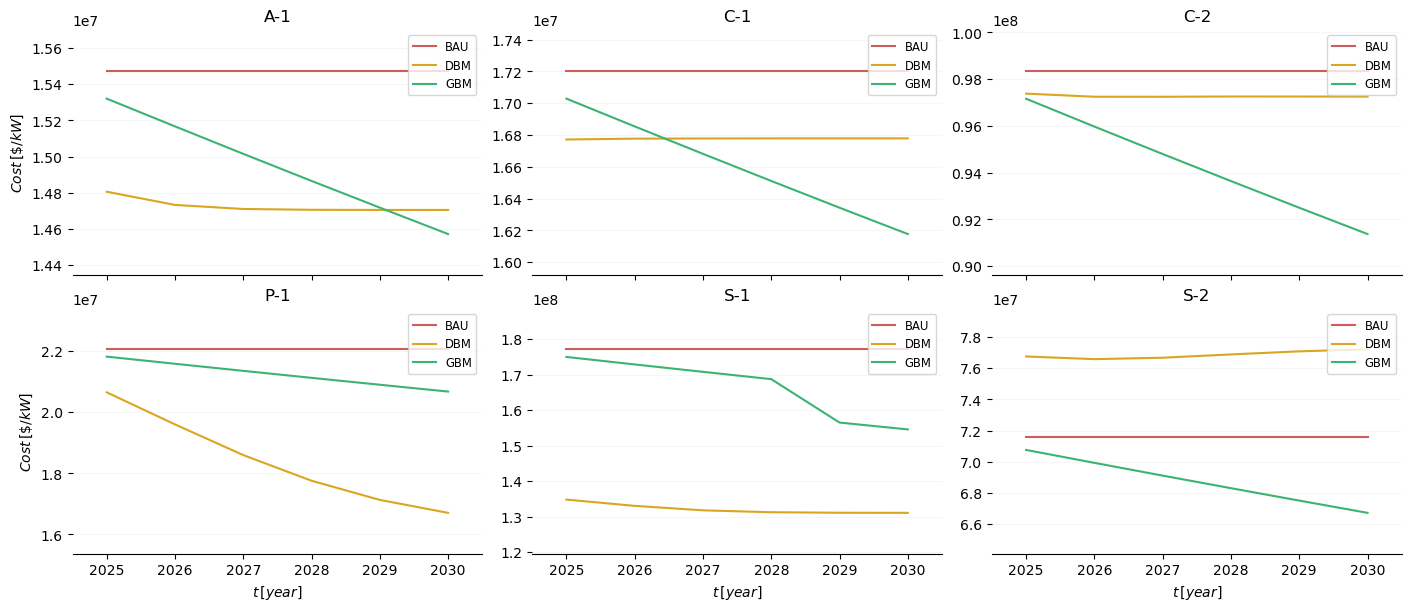

In [69]:
# Annual Compression Capital Cost ($)

df_accc = df_ccc_m*crf
df_accc = df_accc.round(0).astype(int)
display(df_accc)

# Annual Compression O&M Cost DBM ($)

df_acoemc = df_ccc_m*oem
df_acoemc = df_acoemc.round(0).astype(int)
display(df_acoemc)

# Annual Compression Energy Cost DBM ($)

df_acec = df_pr*p_e*cf*24*365
df_acec = df_acec.round(0).astype(int)
display(df_acec)

# Total Annual Compression Cost ($)

df_tccc = df_accc + df_acoemc + df_acec
display(df_tccc)

# Plot

fig, axs = plt.subplots(2, 3, figsize=(14, 6), constrained_layout=True, sharex=True)
axs = axs.flatten()

for company_id, company_name in enumerate(list_of_companies):
    ax = axs[company_id]
    X = df_tccc.index.values
    y_values = None

    # BAU
    column_name = f"{company_name} - BAU"
    data = df_tccc.loc[:, column_name].values
    y_values = data
    ax.plot(X, data, color=COLORS["BAU"], label="BAU")

    # DBM
    column_name = f"{company_name} - DBM"
    data = df_tccc.loc[:, column_name].values
    y_values = np.concatenate((y_values, data))
    ax.plot(X, data, color=COLORS["DBM"], label="DBM")

    # GBM
    column_name = f"{company_name} - GBM"
    data = df_tccc.loc[:, column_name].values
    y_values = np.concatenate((y_values, data))
    ax.plot(X, data, color=COLORS["GBM"], label="GBM")

    config_plot(
        ax,
        y_values,
        x_lim=[2025 - 0.5, 2031 - 0.5],
        title=company_name,
        x_multiplelocator=1,
    )

    if company_id in [0, 3]:
        ax.set_ylabel("$Cost \\, [\$/kW]$")

    if company_id >= 3:
        ax.set_xlabel("$t \\, [year]$")

fig.savefig(f"../img/anual_capital_cost_of_compression.png", dpi=600, bbox_inches="tight")

In [70]:
df_accc = df_accc.reset_index()
df_accc = df_accc.melt(
    id_vars=["Years"], var_name="Original Column", value_name="Value"
)
df_accc[["Group", "Type"]] = df_accc["Original Column"].str.split(" - ", expand=True)
df_accc.drop(columns=["Original Column"], inplace=True)
df_accc.rename(columns={"Value": "Cap"}, inplace=True)
display(df_accc)

df_acoemc = df_acoemc.reset_index()
df_acoemc = df_acoemc.melt(
    id_vars=["Years"], var_name="Original Column", value_name="Value"
)
df_acoemc[["Group", "Type"]] = df_acoemc["Original Column"].str.split(
    " - ", expand=True
)
df_acoemc.drop(columns=["Original Column"], inplace=True)
df_acoemc.rename(columns={"Value": "OEM"}, inplace=True)
display(df_acoemc)

df_acec = df_acec.reset_index()
df_acec = df_acec.melt(
    id_vars=["Years"], var_name="Original Column", value_name="Value"
)
df_acec[["Group", "Type"]] = df_acec["Original Column"].str.split(" - ", expand=True)
df_acec.drop(columns=["Original Column"], inplace=True)
df_acec.rename(columns={"Value": "Power"}, inplace=True)
display(df_acec)

,Years,Cap,Group,Type
0,2025,6594014,A-1,BAU
1,2026,6594014,A-1,BAU
2,2027,6594014,A-1,BAU
3,2028,6594014,A-1,BAU
4,2029,6594014,A-1,BAU
...,...,...,...,...
103,2026,21037767,S-2,GBM
104,2027,20906372,S-2,GBM
105,2028,20775798,S-2,GBM
106,2029,20646040,S-2,GBM


,Years,OEM,Group,Type
0,2025,2585888,A-1,BAU
1,2026,2585888,A-1,BAU
2,2027,2585888,A-1,BAU
3,2028,2585888,A-1,BAU
4,2029,2585888,A-1,BAU
...,...,...,...,...
103,2026,8250105,S-2,GBM
104,2027,8198577,S-2,GBM
105,2028,8147372,S-2,GBM
106,2029,8096486,S-2,GBM


,Years,Power,Group,Type
0,2025,6295931,A-1,BAU
1,2026,6295931,A-1,BAU
2,2027,6295931,A-1,BAU
3,2028,6295931,A-1,BAU
4,2029,6295931,A-1,BAU
...,...,...,...,...
103,2026,40648292,S-2,GBM
104,2027,40013872,S-2,GBM
105,2028,39390370,S-2,GBM
106,2029,38776063,S-2,GBM


In [73]:
df_merged = pd.merge(df_accc, df_acoemc, on=['Years', 'Group', 'Type'], how='outer')
df_final = pd.merge(df_merged, df_acec, on=['Years', 'Group', 'Type'], how='outer')

display(df_final)
df = df_final.loc[:, ["Group", "Type", "Years", "Cap", "OEM", "Power"]]
display(df)

,Years,Cap,Group,Type,OEM,Power
0,2025,6594014,A-1,BAU,2585888,6295931
1,2025,6414699,A-1,DBM,2515568,5874708
2,2025,6552850,A-1,GBM,2569745,6197665
3,2025,7036155,C-1,BAU,2759277,7409614
4,2025,6927887,C-1,DBM,2716818,7126884
...,...,...,...,...,...,...
103,2030,35464772,S-1,DBM,13907754,81721830
104,2030,38573968,S-1,GBM,15127046,100899250
105,2030,21303041,S-2,BAU,8354134,41946440
106,2030,22167304,S-2,DBM,8693060,46347156


,Group,Type,Years,Cap,OEM,Power
0,A-1,BAU,2025,6594014,2585888,6295931
1,A-1,DBM,2025,6414699,2515568,5874708
2,A-1,GBM,2025,6552850,2569745,6197665
3,C-1,BAU,2025,7036155,2759277,7409614
4,C-1,DBM,2025,6927887,2716818,7126884
...,...,...,...,...,...,...
103,S-1,DBM,2030,35464772,13907754,81721830
104,S-1,GBM,2030,38573968,15127046,100899250
105,S-2,BAU,2030,21303041,8354134,41946440
106,S-2,DBM,2030,22167304,8693060,46347156


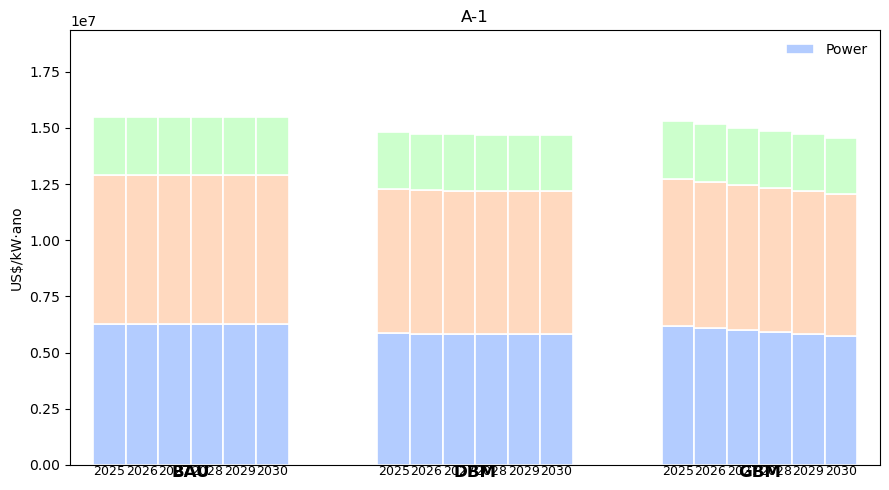

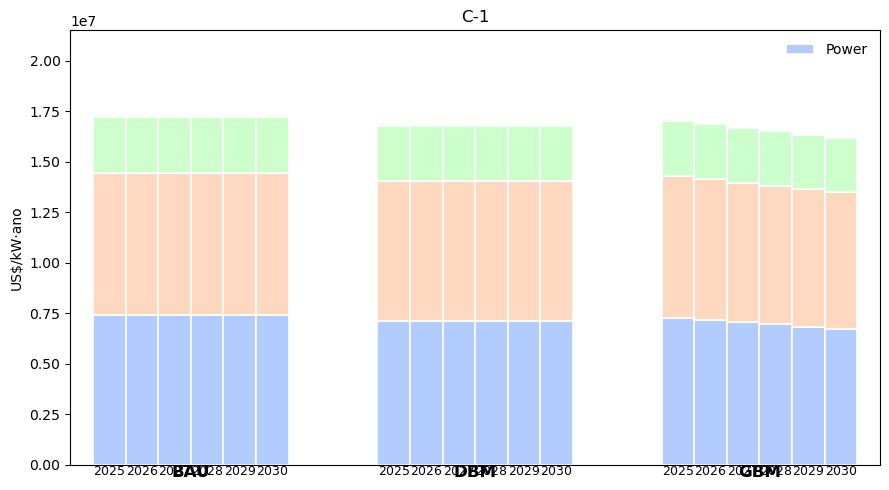

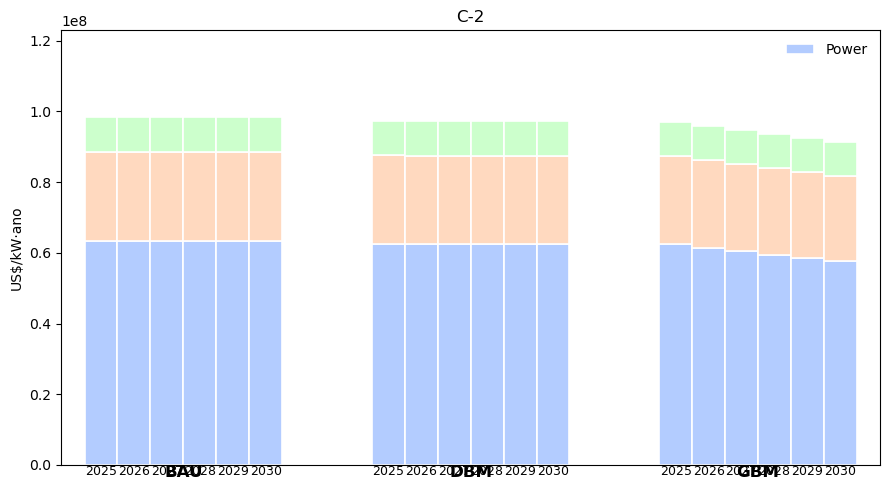

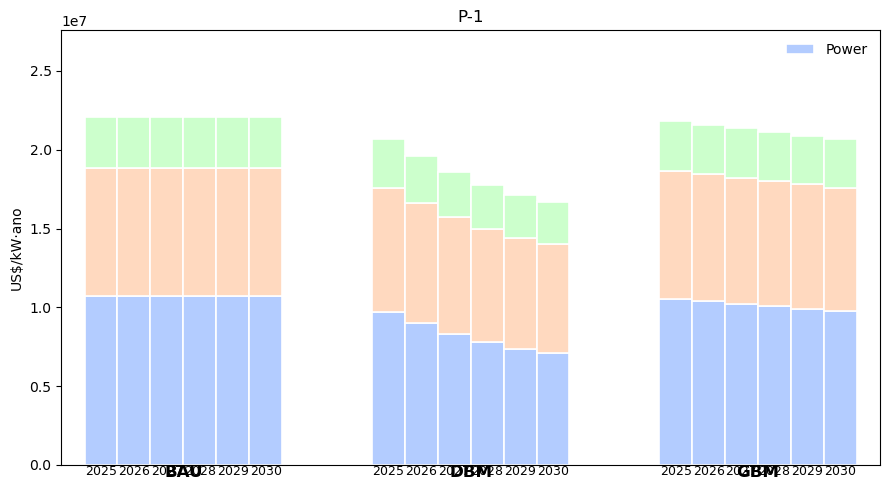

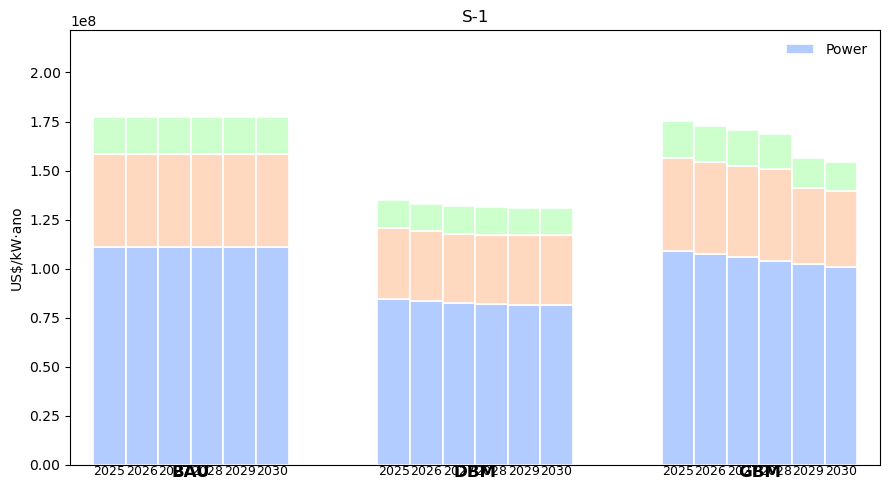

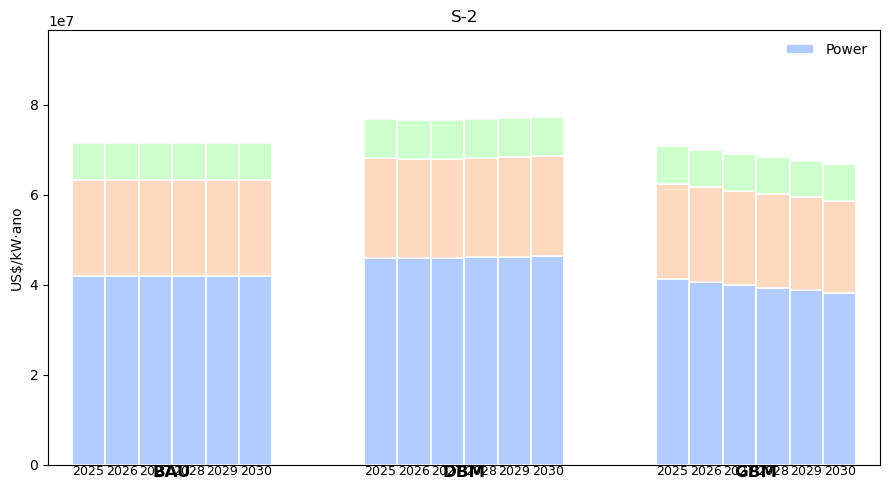

In [84]:
# Parâmetros do layout
scenarios = ["BAU", "DBM", "GBM"]
years = df.Years.unique()
n_years = len(years)
bar_width = 0.22     # largura de cada barra (ano) dentro do grupo
gap = 0.60           # espaço entre grupos de cenários

# Posições dos grupos no eixo X
group_pos = np.arange(len(scenarios)) * (n_years * bar_width + gap)

# Cores suaves e rótulos das fatias
colors = [(0.70, 0.80, 1.00), (1.00, 0.85, 0.75), (0.80, 1.00, 0.80)]
labels = ["Power", "Cap", "OEM"]

for company_name in list_of_companies:
    df_filtered = df[df["Group"] == company_name]

    # -----------------------
    # Plot
    fig, ax = plt.subplots(figsize=(9, 5))

    for i, scen in enumerate(scenarios):
        subset = df_filtered[df_filtered["Type"] == scen]
        for j, year in enumerate(years):
            vals = subset[subset["Years"] == year][["Power", "Cap", "OEM"]].values[0]
            x = group_pos[i] + j * bar_width
            bottom = 0.0
            for k, val in enumerate(vals):
                ax.bar(
                    x, val, width=bar_width, bottom=bottom,
                    color=colors[k], edgecolor="white", linewidth=1.2,
                    label=labels[k] if (i == 0 and j == 0 and k == 0) else None
                )
                bottom += val
            # rótulo do ano sob cada barra
            ax.text(x, -6, year, ha="center", va="top", fontsize=9)

    # rótulo do cenário centralizado sob cada grupo
    for i, scen in enumerate(scenarios):
        xpos = group_pos[i] + (n_years - 1) * bar_width / 2
        ax.text(xpos, -50, scen, ha="center", va="top",
                fontsize=12, fontweight="bold")

    ax.set_ylabel("US$/kW·ano")
    ax.set_xticks([])  # tiramos ticks do x (usamos textos personalizados)
    ax.set_ylim(0, df_filtered[["Power", "Cap", "OEM"]].sum(axis=1).max() * 1.25)
    ax.margins(x=0.03)
    ax.legend(title="", loc="upper right", frameon=False)

    ax.set_title(company_name)

    plt.tight_layout()
    # Salvar figura (opcional)
    # plt.savefig("grouped_stacked_bars.png", dpi=200, bbox_inches="tight")
    plt.show()